# Data Preparation

## Environment Setup

In [ ]:
%pip install -r '../requirements.txt'

In [ ]:
import os
import pandas as pd

In [ ]:
# CONSTANTS
NEWS_API_KEY = os.environ.get('NEWS_API_KEY')

Author - Chandan Rao

This code fetches news articles from the NewsAPI based on a list of search queries read from a CSV file and saves the results into a CSV file

The script can be run as a standalone Python file. Replace 'NEWS_API_KEY' with a valid NewsAPI key and ensure the CSV file (queries.csv) is available with a column named 'search_queries'.

Example content of queries.csv file
- search_queries
- Tata Motors November 2024
- Jio November 2024
- Adani ports November 2024

The code retrieves the following attributes from NewsAPI: 
- source
- author
- title
- description 
- url 
- urlToImage
- publishedAt
- content
- search_query

News Data have been collected from below top 50 Indian companies using the below code.

```companies =
    "Reliance", "TCS", "HDFC Bank", "Bharti Airtel", "ICICI Bank", "Infosys",
    "State Bank of India", "ITC", "Hindustan Unilever", "Life Insurance", "Larsen & Toubro",
    "HCL Technologies", "Sun Pharma", "Bajaj Finance", "NTPC", "M&M",
    "Axis Bank", "Maruti Suzuki", "Kotak Mahindra Bank", "Adani Enterprise", "ONGC",
    "UltraTech Cement", "Wipro", "Tata Motors", "Hindustan Aeronautics", "Adani Ports",
    "Power Grid Corporation", "Titan Company", "Bajaj Finserv", "Bajaj Auto", "Asian Paints",
    "Coal India", "Siemens", "Adani Green", "Avenue Super.", "JSW Steel", "Adani Power",
    "Trent", "Nestle India", "Zomato Ltd", "Bharat Electron", "Hindustan Zinc",
    "Jio Financial", "IOCL", "DLF", "IRFC", "Varun Beverages", "Tata Steel",
    "Vedanta", "LTIMindtree"

In [ ]:
from newsapi import NewsApiClient
from datetime import datetime, timedelta

def read_queries_from_csv(file_path, query_column):
    """
    Read queries from a CSV file

    Parameters:
    file_path (str): Path to the CSV file
    query_column (str): Name of the column containing queries

    Returns:
    list: List of queries
    """
    try:
        # Read CSV file
        df = pd.read_csv(file_path)

        # Check if query column exists
        if query_column not in df.columns:
            raise ValueError(f"Column '{query_column}' not found in CSV file")

        # Extract queries and remove any duplicates and empty values
        queries = df[query_column].dropna().unique().tolist()
        return queries

    except Exception as e:
        print(f"Error reading CSV file: {str(e)}")
        return []

def fetch_news(queries, from_date, to_date, language='en', sort_by='relevancy', page_size=30, api_key=NEWS_API_KEY):
    """
    Fetch news articles for multiple queries using NewsAPI

    Parameters:
    queries (str or list): Single query string or list of query strings
    from_date: Start date for article search
    to_date: End date for article search
    language: Language of articles (default: 'en')
    sort_by: Sorting criteria (default: 'relevancy')
    page_size: Number of articles per query (default: 30)
    api_key: NewsAPI API key

    Returns:
    pandas.DataFrame: Combined results from all queries
    """
    # Initialize the NewsAPI client
    newsapi = NewsApiClient(api_key=api_key)

    # Convert single query to list if necessary
    if isinstance(queries, str):
        queries = [queries]

    # List to store all dataframes
    all_dfs = []

    # Process each query
    for query in queries:
        # Replace spaces with '&' for API
        formatted_query = query.replace(' ', '&')

        # Fetch articles for current query
        try:
            all_articles = newsapi.get_everything(
                q=formatted_query,
                from_param=from_date,
                to=to_date,
                language=language,
                sort_by=sort_by,
                page_size=page_size
            )

            # Extract articles
            articles = all_articles.get('articles', [])

            # Convert to DataFrame and add query column
            if articles:
                df = pd.DataFrame(articles)
                df['search_query'] = query  # Add original query for reference
                all_dfs.append(df)
                print(f"Successfully fetched {len(articles)} articles for query: {query}")

        except Exception as e:
            print(f"Error fetching articles for query '{query}': {str(e)}")
            continue

    # Combine all results
    if all_dfs:
        final_df = pd.concat(all_dfs, ignore_index=True)
        return final_df
    else:
        return pd.DataFrame()

# Example usage
if __name__ == "__main__":
    current_time = datetime.now()
    time_30_days_ago = current_time - timedelta(days=30)
    api_key = NEWS_API_KEY

    # Path to your CSV file
    csv_file_path = '../Dataset/scraper/raw/queries.csv'
    query_column_name = 'search_queries'  # The column name in your CSV that contains the queries

    # Read queries from CSV
    queries = read_queries_from_csv(csv_file_path, query_column_name)

    if queries:
        print(f"Found {len(queries)} queries in CSV file")
        # Fetch news for all queries
        df = fetch_news(queries, time_30_days_ago, current_time, api_key=api_key)

        # Save to CSV
        output_file = '../Dataset/scraper/raw/NewsDataset.csv'
        df.to_csv(output_file, index=False)
        print(f"Results saved to {output_file}")
    else:
        print("No queries found in CSV file")

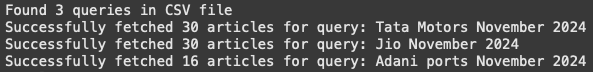